<a href="https://colab.research.google.com/github/saumyaya/AI-ML-Projects/blob/main/facial_recognition_using_lfw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install scikit-plot

In [ ]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
import os
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [ ]:
import zipfile
import io

# Specify the file name of the uploaded ZIP file
zip_file_name = 'archive.zip'

# Open the uploaded ZIP file
with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    # Extract all contents of the ZIP file to a directory (e.g., 'extracted_data/')
    zip_ref.extractall('extracted_data/')

In [ ]:
import pandas as pd
import os

# List files in the extracted directory
extracted_files = os.listdir('extracted_data/')

# Example: Read a CSV file from the extracted directory
lfw_allnames = pd.read_csv('extracted_data/lfw_allnames.csv')
matchpairsDevTest = pd.read_csv('extracted_data/matchpairsDevTest.csv')
matchpairsDevTrain = pd.read_csv("extracted_data/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("extracted_data/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("extracted_data/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("extracted_data/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("extracted_data/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("extracted_data/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("extracted_data/peopleDevTrain.csv")

1. **lfw_allnames.csv:** a CSV containing two columns; name (a list of all names in the entire dataset) and images (the number of images available for the each name)
2. **matchpairsDevTest:** a random sample of 500 image pairs featuring the same individual, with columns for the name and the two image labels
matchpairsDevTrain: a random sample of 1100 image pairs featuring the same individual, with columns for the name and the image labels
3. **mismatchpairsDevTest:** a random sample of 500 image pairs featuring different individuals, with columns for both names and the two image labels
4. **mismatchpairsDevTrain:** a random sample of 1100 image pairs featuring different individuals, with columns for both names and the two image labels
5. **pairs.csv:** 6000 pairs of images, both matched and mismatched. Matched pair rows contain a name and two image files, while unmatched pair rows contain a name for each of the images. For further formating, these two sets of rows will be split into matched_pairs and unmatched_pairs data frames
6. **people.csv:** list of names and image counts, identical to lfw_allnames.csv once null values have been removed. Omit from further analysis
7. **peopleDevTest.csv:** 1711 individuals in the dataset designed for testing: columns for celebrity name and image count (zero overlap with peopleDevTrain.csv)
8. **peopleDevTrain.csv:** 4038 individuals in the dataset designed for training: columns for celebrity name and image count (zero overlap with peopleDevTest.csv)

# **Exploratory Data Analysis (EDA)**

In [ ]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

855
872


In [ ]:
# verify resolution of all images is consistent
from PIL import Image
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "extracted_data/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()


,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


<Axes: >

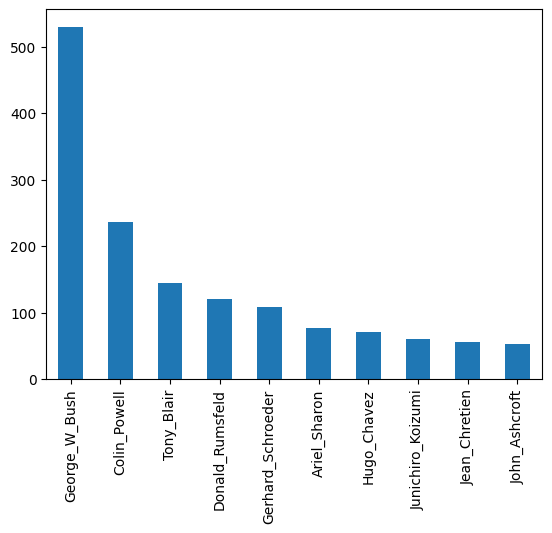

In [ ]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [ ]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


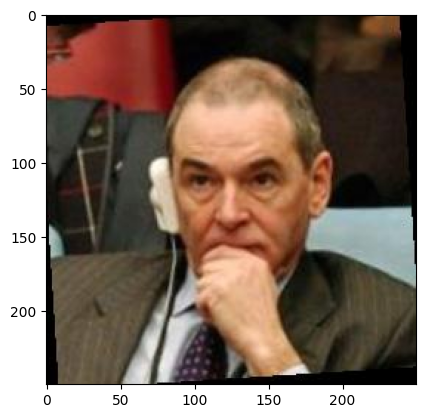

In [ ]:
im = Image.open("extracted_data/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

In [ ]:
pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.0 MB/s eta 0:00:00


In [ ]:
from mtcnn.mtcnn import MTCNN
import cv2
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("extracted_data/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']


1/1 [==============================] - 1s 520ms/step


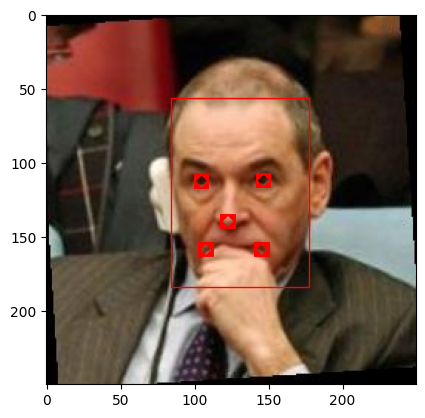

In [ ]:
import matplotlib.patches as patches
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

In [ ]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [ ]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [ ]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
# use sequential classifier - standard CNN implementation with straightforward single input
Bush_classifier = Sequential()
# We then add layers of complexity to this classifier. The first layer we add is a 2D convolutional layer (as
# explained above); we pass over the image with a 3x3 window and expect 250*250 pixel input.
# The activation function to introduce non-linearity  is 'relu': Rectified Linear Units, a simple activation function
# with low computational speeds. One potential downside is that ReLU can lead to "dying neurons", where a neuron is
# attributed zero influence on classification and gets stuck in this state; we can see output where many neurons have
# zero influence on the model. If this behaviour manifested in further analysis, an alternate activation function e.g.
# 'leaky ReLU' would be worth exploring as an alternative
Bush_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))


In [ ]:
# We now add the pooling layer to reduce the dimension
Bush_classifier.add(MaxPooling2D(pool_size = (2, 2)))

# The next step is to flatten the data, reducing the feature maps to a 1D array
Bush_classifier.add(Flatten())

# We then add a fully connected layer - traditional Multi Layer Perceptron
Bush_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are just training on 'Bush' vs 'non-Bush', we only need to add one classification unit
Bush_classifier.add(Dense(units = 1, activation = 'sigmoid'))

# We are now ready to compile the model. It is possible, and advisable, to introduce more layers to the network, but
# as this model is exploratory we are keeping things straightforward for now (this would change in future iterations)
Bush_classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
import shutil
import os

def directory_mover(data, dir_name):
    # Define the base directory based on your environment (modify as needed)
    base_directory = '/content/'
    for image in data['image_path']:
        # Create the top-level directory if it doesn't exist
        if not os.path.exists(os.path.join(base_directory, dir_name)):
            os.mkdir(os.path.join(base_directory, dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])

        # Create the data_type directory if it doesn't exist
        if not os.path.exists(os.path.join(base_directory, dir_name, data_type)):
            os.mkdir(os.path.join(base_directory, dir_name, data_type))

        path_from = os.path.join('extracted_data/lfw-deepfunneled/lfw-deepfunneled/', image)
        path_to = os.path.join(base_directory, dir_name, data_type, os.path.basename(image))

        shutil.copy(path_from, path_to)

    print('Moved {} images to {} folder.'.format(len(data), dir_name))


In [ ]:
directory_mover(bush_train, "Bush_train/")
directory_mover(bush_val, "Bush_val/")
directory_mover(bush_test, "Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
Bush_training_set = train_datagen.flow_from_directory('/content/Bush_train/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('/content/Bush_val/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('/content/Bush_test/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [ ]:
import os

# Specify the path to your training dataset
train_data_dir = '/content/Bush_train/'

# Count the number of image files in the training directory
total_training_samples = sum([len(files) for root, dirs, files in os.walk(train_data_dir)])

# Specify your batch size
batch_size = 32

# Calculate steps_per_epoch
steps_per_epoch = total_training_samples // batch_size
print(steps_per_epoch)


21


In [ ]:
Bush_history = Bush_classifier.fit_generator(Bush_training_set,
                                             steps_per_epoch = 21,
                                             epochs = 10,
                                             validation_data = Bush_val_set,
                                             validation_steps = 100)

Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9536

21/21 [==============================] - 11s 514ms/step - loss: 0.1270 - accuracy: 0.9536 - val_loss: 0.3546 - val_accuracy: 0.9235
Epoch 2/15
21/21 [==============================] - 8s 375ms/step - loss: 0.1841 - accuracy: 0.9226
Epoch 3/15
21/21 [==============================] - 9s 426ms/step - loss: 0.1226 - accuracy: 0.9567
Epoch 4/15
21/21 [==============================] - 9s 426ms/step - loss: 0.1363 - accuracy: 0.9443
Epoch 5/15
21/21 [==============================] - 9s 416ms/step - loss: 0.2012 - accuracy: 0.9133
Epoch 6/15
21/21 [==============================] - 8s 381ms/step - loss: 0.1641 - accuracy: 0.9365
Epoch 7/15
21/21 [==============================] - 10s 506ms/step - loss: 0.1018 - accuracy: 0.9628
Epoch 8/15
21/21 [==============================] - 9s 431ms/step - loss: 0.1319 - accuracy: 0.9567
Epoch 9/15
21/21 [==============================] - 9s 420ms/step - loss: 0.1334 - accuracy: 0.9505
Epoch 10/15
21/21 [==============================] - 8s 375ms/step 

In [ ]:
Bush_classifier.save('../output/my_model.h5')

In [ ]:
Bush_classifier.fit(X, y)
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

NameError: ignored

In [ ]:
Bush_history.history['val_accuracy']

[0.9235293865203857]

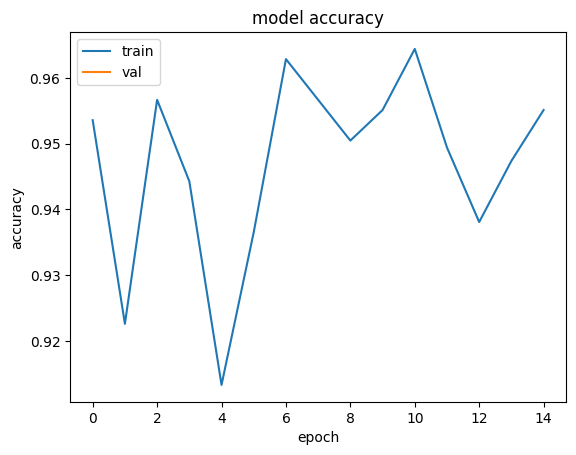

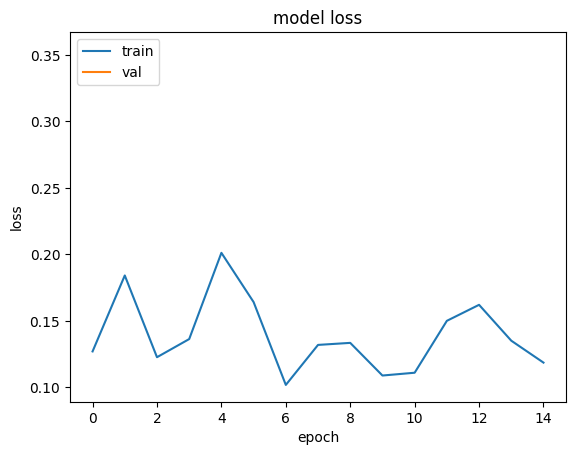

In [ ]:
plt.plot(Bush_history.history['accuracy'])
plt.plot(Bush_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(Bush_history.history['loss'])
plt.plot(Bush_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
prediction = Bush_classifier.predict(Bush_test_set)

7/7 [==============================] - 1s 101ms/step


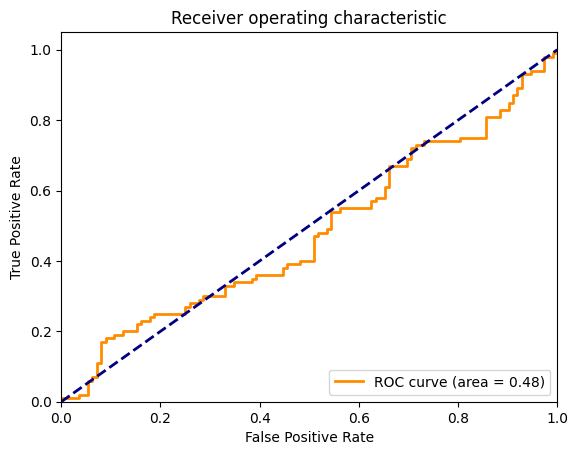

In [ ]:
# ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds  = roc_curve(Bush_test_set.classes, prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)

In [ ]:
from collections import OrderedDict
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
Bush_test_names = []
# collect all file names
for i in range(len(Bush_test_set.filenames)):
    Bush_test_names.append(Bush_test_set.filenames[i])
# extract unique names, in order
for i in range(len(Bush_test_names)):
    Bush_test_names[i] = Bush_test_names[i].split("/")[0]
Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [ ]:
# Compute predictions
Bush_predictions_0 = predictions("/content/Bush_test/"+ Bush_test_name_order[0] + "/",Bush_classifier,binary = True)
Bush_predictions_1 = predictions("/content/Bush_test/"+ Bush_test_name_order[1] + "/",Bush_classifier, binary = True)

# Compare predictions to actual classes
Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
                                                [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
                                       columns = ['Predictions','Actual'])

1/1 [==============================] - 0s 18ms/step


In [ ]:
# function for finding the precision and recall of predictions, for any number of predictive classes
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame.Predictions))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]
        if (tp + fp)!= 0:
          precision.append(tp/(tp + fp))
        elif (tp + fn)!= 0:
          recall.append(tp/(tp + fn))
        elif total_preds!= 0:
          accuracy.append((tp + tn)/total_preds)
        elif (tp + fp)== 0:
          precision.append(0.0)
        elif (tp + fn)== 0:
          recall.append(0.0)
        elif total_preds== 0:
          accuracy.append(0.0)

    return(accuracy,precision,recall)

In [ ]:
Bush_accuracy = prec_acc(Bush_predictions_frame)
print('Accuracy:' + str(Bush_accuracy[0]))
print('Precision:' + str(Bush_accuracy[1]))
print('Recall:' + str(Bush_accuracy[2]))
print(Bush_test_name_order)

Accuracy:[1.0]
Precision:[0.9137931034482759, 0.9473684210526315]
Recall:[]
['George_W_Bush', 'not_George']


In [ ]:
if "Bush_train" in os.listdir("./"):
    shutil.rmtree("./Bush_train")
if "Bush_val" in os.listdir("./"):
    shutil.rmtree("./Bush_val")
if "Bush_test" in os.listdir("./"):
    shutil.rmtree("./Bush_test")

In [ ]:
image_paths['name'].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [ ]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

In [ ]:
# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()
multi_classifier.add(Conv2D(32, (3, 3), input_shape = (250, 250, 3), activation = 'relu'))
multi_classifier.add(MaxPooling2D(pool_size = (2, 2)))
multi_classifier.add(Flatten())
multi_classifier.add(Dense(units = 128, activation = 'relu'))

# as we are training on several classes, we need several classification units (one for each class). We also use a
# softmax activation function
multi_classifier.add(Dense(units = 6, activation = 'softmax'))
# we change the loss function to categorical_crossentropy
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/content/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/content/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/content/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'categorical')


multi_history = multi_classifier.fit_generator(multi_training_set,
                                               steps_per_epoch =9,
                                               epochs = 10,
                                               validation_data = multi_val_set,
                                               validation_steps = 72)

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 90 images belonging to 6 classes.
Epoch 1/10
9/9 [==============================] - 4s 395ms/step - loss: 0.1400 - accuracy: 0.9722
Epoch 2/10
9/9 [==============================] - 4s 398ms/step - loss: 0.1181 - accuracy: 0.9792
Epoch 3/10
9/9 [==============================] - 5s 546ms/step - loss: 0.1321 - accuracy: 0.9479
Epoch 4/10
9/9 [==============================] - 4s 410ms/step - loss: 0.0769 - accuracy: 0.9826
Epoch 5/10
9/9 [==============================] - 4s 392ms/step - loss: 0.1030 - accuracy: 0.9618
Epoch 6/10
9/9 [==============================] - 5s 536ms/step - loss: 0.0883 - accuracy: 0.9826
Epoch 7/10
9/9 [==============================] - 4s 397ms/step - loss: 0.0876 - accuracy: 0.9826
Epoch 8/10
9/9 [==============================] - 4s 396ms/step - loss: 0.0

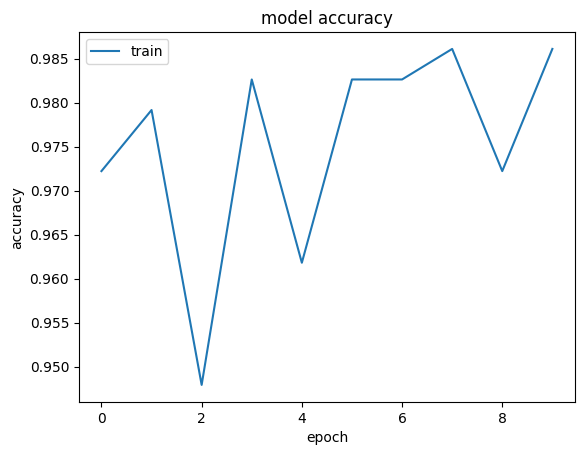

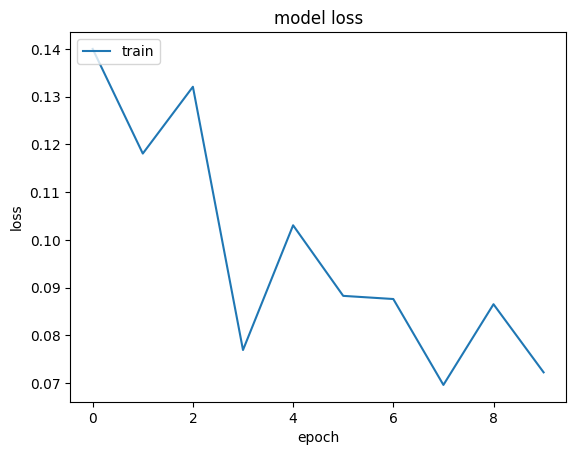

In [ ]:
plt.plot(multi_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

plt.plot(multi_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


In [ ]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [ ]:
multi_predictions_0 = predictions("/content/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/content/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/content/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/content/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/content/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/content/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)

1/1 [==============================] - 0s 20ms/step


In [ ]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[1.0, 0.7058823529411765, 0.5714285714285714, 0.6666666666666666, 0.875, 0.41379310344827586]
Recall:[]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


In [ ]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")